In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from sklearn.manifold import TSNE
from collections import Counter
import re

In [2]:
# for kaggle
# path = "/kaggle/input/datasets/temaetotema/cvae-train/data.csv"
# df = pd.read_csv(path)

# for local
candidates = [
    Path("Data/processed/master_dataset.csv"),   # if cwd = root
    Path("../processed/master_dataset.csv"),     # if cwd = Data/notebooks
]

# candidates = [
#     Path("Data/processed/data.csv"),   # if cwd = root
#     Path("../processed/data.csv"),     # if cwd = Data/notebooks
# ]

path = next((p for p in candidates if p.exists()), None)
if path is None:
    raise FileNotFoundError("Error: no in Data/processed/data.csv (проверь cwd и структуру папок)")

df = pd.read_csv(path)

id_col = 'APD ID'
seq_col = 'Sequence'
len_col = 'Length'
condition_cols = [
    'is_antibacterial', 'is_anti_gram_positive', 'is_anti_gram_negative',
    'is_antifungal', 'is_antiviral', 'is_antiparasitic', 'is_anticancer'
]

existing_cols = [col for col in [id_col, seq_col, len_col] + condition_cols if col in df.columns]
df = df[existing_cols].dropna(subset=[seq_col])

for col in condition_cols:
    if col in df.columns:
        df[col] = df[col].astype(int)

df["Length"] = df["Length"].astype("Int64")
print(f"Size after cleaning: {df.shape}")
df.head()

Size after cleaning: (6251, 10)


,APD ID,Sequence,Length,is_antibacterial,is_anti_gram_positive,is_anti_gram_negative,is_antifungal,is_antiviral,is_antiparasitic,is_anticancer
0,AP05452,AAAGKHKNKGKKNGKHNGWK,20,1,1,1,1,0,0,0
1,AP05433,AAAHKHGHGHGKHKNKGKKN,20,1,1,1,1,0,0,0
2,AP01515,AACSDRAHGHICESFKSFCKDSGRNGVKLRANCKKTCGLC,40,1,1,1,0,0,0,0
3,AP00612,AAEFPDFYDSEEQMGPHQEAEDEKDRADQRVLTEEEKKELENLAAM...,60,1,1,1,0,0,0,0
4,AP01914,AAFRGCWTKNYSPKPCL,17,1,1,0,0,0,0,0


In [6]:
all_chars = set()
for seq in df[seq_col]:
    all_chars.update(seq)

special_tokens = ['<PAD>', '<SOS>', '<EOS>', '<UNK>']
vocab_list = special_tokens + sorted(all_chars)
char2idx = {ch: i for i, ch in enumerate(vocab_list)}
idx2char = {i: ch for ch, i in char2idx.items()}
vocab_size = len(vocab_list)

print(f"Vocab size: {vocab_size}")
print("Words:", list(all_chars)[:10])

Vocab size: 32
Words example: ['X', 'M', 'N', 'Z', 'H', 'Q', 'V', 'R', 'a', 'U']


In [7]:
def tokenize(seq, char2idx, max_len, add_sos_eos=True):
    tokens = [char2idx.get(ch, char2idx['<UNK>']) for ch in seq]
    if add_sos_eos:
        tokens = [char2idx['<SOS>']] + tokens + [char2idx['<EOS>']]
    # паддинг
    if len(tokens) < max_len:
        tokens += [char2idx['<PAD>']] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens

# Определим максимальную длину (с учётом SOS/EOS)
max_len = df[len_col].max() + 2  # +2 для SOS и EOS

# Токенизируем все последовательности
tokenized_seqs = []
for seq in df[seq_col]:
    tokenized = tokenize(seq, char2idx, max_len, add_sos_eos=True)
    tokenized_seqs.append(tokenized)

# Condition векторы
conditions = df[condition_cols].values.astype(np.float32)  # форма (N, 7)

# Исходные длины (без паддинга) – пригодятся для pack_padded_sequence
real_lengths = np.array([len(seq) + 2 for seq in df[seq_col]])  # +2 SOS/EOS
real_lengths = np.minimum(real_lengths, max_len)

print(f"Max len after pad: {real_lengths}")

Max len after pad: [22 22 42 ... 22 20 28]


In [8]:
class AMPDataset(Dataset):
    def __init__(self, sequences, lengths, conditions):
        self.sequences = torch.LongTensor(sequences)
        self.lengths = torch.LongTensor(lengths)
        self.conditions = torch.FloatTensor(conditions)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.lengths[idx], self.conditions[idx]

dataset = AMPDataset(tokenized_seqs, real_lengths, conditions)

# Разделение на train/val/test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 5000, Val: 625, Test: 626


In [9]:
# cVAE architecture

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, latent_dim, cond_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=char2idx['<PAD>'])
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, bidirectional=False, dropout=dropout)
        self.fc_mu = nn.Linear(hidden_dim + cond_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim + cond_dim, latent_dim)

    def forward(self, x, lengths, cond):
        # x: (batch, seq_len)
        # print("x.shape:", x.shape)
        # print("lengths.max():", int(lengths.max()), "x.size(1):", x.size(1))
        # assert int(lengths.max()) <= x.size(1)
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hidden = self.gru(packed)  # hidden: (1, batch, hidden_dim)
        hidden = hidden.squeeze(0)    # (batch, hidden_dim)
        # Конкатенация с condition
        hidden_cond = torch.cat([hidden, cond], dim=1)  # (batch, hidden_dim+cond_dim)
        mu = self.fc_mu(hidden_cond)
        logvar = self.fc_logvar(hidden_cond)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, latent_dim, cond_dim, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=char2idx['<PAD>'])
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        # Сеть для начального состояния декодера из z и cond
        self.init_h = nn.Linear(latent_dim + cond_dim, hidden_dim)

    def forward(self, x, lengths, z, cond, teacher_forcing_ratio=1.0):
        # x: (batch, seq_len-1) вход для декодера (сдвинутая версия target)
        batch_size, seq_len = x.shape
        # Начальное состояние
        z_cond = torch.cat([z, cond], dim=1)  # (batch, latent+cond)
        h0 = self.init_h(z_cond).unsqueeze(0) # (1, batch, hidden)

        embedded = self.embedding(x)  # (batch, seq_len, embed_dim)
        outputs, _ = self.gru(embedded, h0)  # (batch, seq_len, hidden)
        logits = self.fc_out(outputs)  # (batch, seq_len, vocab_size)
        return logits

class CVAE(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, latent_dim, cond_dim, dropout=0.2):
        super().__init__()
        self.encoder = Encoder(vocab_size, embed_dim, hidden_dim, latent_dim, cond_dim, dropout)
        self.decoder = Decoder(vocab_size, embed_dim, hidden_dim, latent_dim, cond_dim, dropout)
        self.latent_dim = latent_dim

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, src, lengths, cond, teacher_forcing_ratio=1.0):
        # src включает <SOS> и <EOS>, форма (batch, max_len)
        # Энкодер
        mu, logvar = self.encoder(src, lengths, cond)
        z = self.reparameterize(mu, logvar)
        # Декодер: входом будет src без последнего токена (убираем <EOS>)
        decoder_input = src[:, :-1]  # (batch, max_len-1)
        target = src[:, 1:]          # (batch, max_len-1) – то, что должны предсказать
        logits = self.decoder(decoder_input, lengths-1, z, cond, teacher_forcing_ratio)
        return logits, target, mu, logvar

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Гиперпараметры
embed_dim = 64
hidden_dim = 128
latent_dim = 32
cond_dim = len(condition_cols)
dropout = 0.2
lr = 1e-3

model = CVAE(vocab_size, embed_dim, hidden_dim, latent_dim, cond_dim, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=char2idx['<PAD>'])

def loss_function(logits, target, mu, logvar, beta=1.0):
    # logits: (batch, seq_len, vocab)
    # target: (batch, seq_len)
    recon_loss = criterion(logits.reshape(-1, vocab_size), target.reshape(-1))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl_loss /= target.size(0)  # усредняем по батчу
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

Using device: cpu


C:\Users\artem\Study\PMLaDL\.venv\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [13]:
def train_epoch(model, loader, optimizer, beta=1.0):
    model.train()
    total_loss = 0
    for src, lengths, cond in loader:
        src, lengths, cond = src.to(device), lengths.to(device), cond.to(device)
        optimizer.zero_grad()
        logits, target, mu, logvar = model(src, lengths, cond)
        loss, recon, kl = loss_function(logits, target, mu, logvar, beta)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader, beta=1.0):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, lengths, cond in loader:
            src, lengths, cond = src.to(device), lengths.to(device), cond.to(device)
            logits, target, mu, logvar = model(src, lengths, cond)
            loss, _, _ = loss_function(logits, target, mu, logvar, beta)
            total_loss += loss.item()
    return total_loss / len(loader)

# Обучение
num_epochs = 150
best_val_loss = float('inf')
patience = 5
counter = 0

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_loss = eval_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_cvae.pt')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load('best_cvae.pt'))

Epoch 1/150, Train Loss: 3.2870, Val Loss: 2.9387
Epoch 2/150, Train Loss: 2.8736, Val Loss: 2.8059
Epoch 3/150, Train Loss: 2.7866, Val Loss: 2.7434
Epoch 4/150, Train Loss: 2.7372, Val Loss: 2.7031
Epoch 5/150, Train Loss: 2.7015, Val Loss: 2.6730
Epoch 6/150, Train Loss: 2.6703, Val Loss: 2.6408
Epoch 7/150, Train Loss: 2.6380, Val Loss: 2.6057
Epoch 8/150, Train Loss: 2.6031, Val Loss: 2.5694
Epoch 9/150, Train Loss: 2.5704, Val Loss: 2.5387
Epoch 10/150, Train Loss: 2.5370, Val Loss: 2.5091
Epoch 11/150, Train Loss: 2.5122, Val Loss: 2.4862
Epoch 12/150, Train Loss: 2.4868, Val Loss: 2.4649
Epoch 13/150, Train Loss: 2.4651, Val Loss: 2.4458
Epoch 14/150, Train Loss: 2.4432, Val Loss: 2.4307
Epoch 15/150, Train Loss: 2.4226, Val Loss: 2.4075
Epoch 16/150, Train Loss: 2.4022, Val Loss: 2.3902
Epoch 17/150, Train Loss: 2.3820, Val Loss: 2.3738
Epoch 18/150, Train Loss: 2.3624, Val Loss: 2.3567
Epoch 19/150, Train Loss: 2.3451, Val Loss: 2.3421
Epoch 20/150, Train Loss: 2.3284, Val Lo

<All keys matched successfully>

In [14]:
def generate(model, cond, max_gen_len=50, temperature=1.0):
    model.eval()
    with torch.no_grad():
        cond = torch.FloatTensor(cond).unsqueeze(0).to(device)  # (1, cond_dim)
        # Сэмплируем z из N(0,1)
        z = torch.randn(1, latent_dim).to(device)
        # Начальное состояние декодера
        z_cond = torch.cat([z, cond], dim=1)
        h = model.decoder.init_h(z_cond).unsqueeze(0)  # (1,1,hidden)

        input_token = torch.LongTensor([[char2idx['<SOS>']]]).to(device)
        generated = []
        for _ in range(max_gen_len):
            embedded = model.decoder.embedding(input_token)  # (1,1,embed)
            output, h = model.decoder.gru(embedded, h)       # output: (1,1,hidden)
            logits = model.decoder.fc_out(output.squeeze(1)) # (1, vocab)
            # Temperature sampling
            probs = torch.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
            if next_token == char2idx['<EOS>']:
                break
            generated.append(next_token)
            input_token = torch.LongTensor([[next_token]]).to(device)

        # Преобразуем индексы в строку
        seq = ''.join([idx2char[idx] for idx in generated if idx not in [char2idx['<PAD>'], char2idx['<SOS>'], char2idx['<EOS>']]])
        return seq

cond_gram_pos = [0,1,0,0,0,0,0]  # is_antibacterial=0, gram_pos=1, ...
print("Sample of generation for Gram+:")
for i in range(5):
    seq = generate(model, cond_gram_pos)
    print(f"{i+1}: {seq}")

Sample of generation for Gram+:
1: KCWKGYGYKGYGNGPWEEYNVGMANGYYCAGGHCYGGVCYTP
2: SLRSLVGDSFGGGGGGGGGGGRRKGECKGREIIDKIVRRPRR
3: KICGESCVYIPCATSSGVCYGYIPDGTLPCMISCKSQKCYCD
4: SKIRQKIKNFFQKL
5: GIKEVIKEEIKKIIKN


In [15]:
def evaluate_generation(model, cond, num_samples=10, train_seqs_set=None):
    generated_seqs = []
    for _ in range(num_samples):
        seq = generate(model, cond)
        generated_seqs.append(seq)

    # Validity: все символы принадлежат словарю (не специальные)
    valid_seqs = []
    for seq in generated_seqs:
        if all(ch in char2idx and char2idx[ch] not in [char2idx['<PAD>'], char2idx['<SOS>'], char2idx['<EOS>'], char2idx['<UNK>']] for ch in seq):
            valid_seqs.append(seq)
    validity = len(valid_seqs) / num_samples

    # Uniqueness
    unique_seqs = set(valid_seqs)
    uniqueness = len(unique_seqs) / len(valid_seqs) if valid_seqs else 0

    # Novelty
    if train_seqs_set is not None:
        novel_seqs = [s for s in unique_seqs if s not in train_seqs_set]
        novelty = len(novel_seqs) / len(unique_seqs) if unique_seqs else 0
    else:
        novelty = None

    return validity, uniqueness, novelty, valid_seqs

# Получаем все тренировочные последовательности (без токенов)
train_seqs_raw = [df.iloc[i][seq_col] for i in train_dataset.indices]
train_seqs_set = set(train_seqs_raw)

# Оцениваем для Gram+
val_gp, uniq_gp, nov_gp, seqs_gp = evaluate_generation(model, cond_gram_pos, num_samples=200, train_seqs_set=train_seqs_set)
print(f"Gram+ : Validity={val_gp:.3f}, Uniqueness={uniq_gp:.3f}, Novelty={nov_gp:.3f}")

# Для Gram- (is_anti_gram_negative=1)
cond_gram_neg = [0,0,1,0,0,0,0]
val_gn, uniq_gn, nov_gn, seqs_gn = evaluate_generation(model, cond_gram_neg, num_samples=200, train_seqs_set=train_seqs_set)
print(f"Gram- : Validity={val_gn:.3f}, Uniqueness={uniq_gn:.3f}, Novelty={nov_gn:.3f}")

Gram+ : Validity=1.000, Uniqueness=1.000, Novelty=1.000
Gram- : Validity=1.000, Uniqueness=0.970, Novelty=0.954


In [16]:
# parametric t-SNE
# Функция получения латентных векторов для набора данных
def get_latent_vectors(model, loader):
    model.eval()
    latents = []
    conditions = []
    with torch.no_grad():
        for src, lengths, cond in loader:
            src, lengths, cond = src.to(device), lengths.to(device), cond.to(device)
            mu, _ = model.encoder(src, lengths, cond)
            latents.append(mu.cpu().numpy())
            conditions.append(cond.cpu().numpy())
    return np.concatenate(latents, axis=0), np.concatenate(conditions, axis=0)

# Получаем латентные векторы для всего тренировочного набора
train_latents, train_conds = get_latent_vectors(model, train_loader)
print(f"Train latents shape: {train_latents.shape}")

Train latents shape: (5000, 32)


In [17]:
# Обычный t-SNE на латентных векторах
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
train_2d = tsne.fit_transform(train_latents)

# Обучаем небольшую нейросеть регрессии (parametric t-SNE)
class ParametricTSNE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x):
        return self.net(x)

pt_model = ParametricTSNE(latent_dim).to(device)
pt_optimizer = optim.Adam(pt_model.parameters(), lr=1e-3)
pt_criterion = nn.MSELoss()

# Превращаем данные в тензоры
X_pt = torch.FloatTensor(train_latents).to(device)
Y_pt = torch.FloatTensor(train_2d).to(device)

# Обучение
pt_epochs = 2000
batch_size_pt = 256
dataset_pt = torch.utils.data.TensorDataset(X_pt, Y_pt)
loader_pt = DataLoader(dataset_pt, batch_size=batch_size_pt, shuffle=True)

for epoch in range(pt_epochs):
    total_loss = 0
    for xb, yb in loader_pt:
        pt_optimizer.zero_grad()
        pred = pt_model(xb)
        loss = pt_criterion(pred, yb)
        loss.backward()
        pt_optimizer.step()
        total_loss += loss.item()
    if (epoch+1) % 50 == 0:
        print(f"PT-SNE Epoch {epoch+1}/{pt_epochs}, Loss: {total_loss/len(loader_pt):.6f}")

torch.save(pt_model.state_dict(), 'parametric_tsne.pt')

PT-SNE Epoch 50/2000, Loss: 1276.800934
PT-SNE Epoch 100/2000, Loss: 1260.532483
PT-SNE Epoch 150/2000, Loss: 1220.115668
PT-SNE Epoch 200/2000, Loss: 1170.548840
PT-SNE Epoch 250/2000, Loss: 1110.477936
PT-SNE Epoch 300/2000, Loss: 1049.955502
PT-SNE Epoch 350/2000, Loss: 985.878400
PT-SNE Epoch 400/2000, Loss: 926.489917
PT-SNE Epoch 450/2000, Loss: 869.980814
PT-SNE Epoch 500/2000, Loss: 819.157047
PT-SNE Epoch 550/2000, Loss: 770.278818
PT-SNE Epoch 600/2000, Loss: 728.873856
PT-SNE Epoch 650/2000, Loss: 694.422159
PT-SNE Epoch 700/2000, Loss: 664.549835
PT-SNE Epoch 750/2000, Loss: 633.065460
PT-SNE Epoch 800/2000, Loss: 607.584158
PT-SNE Epoch 850/2000, Loss: 587.930545
PT-SNE Epoch 900/2000, Loss: 570.287344
PT-SNE Epoch 950/2000, Loss: 554.774553
PT-SNE Epoch 1000/2000, Loss: 544.750319
PT-SNE Epoch 1050/2000, Loss: 534.176331
PT-SNE Epoch 1100/2000, Loss: 529.266757
PT-SNE Epoch 1150/2000, Loss: 521.186601
PT-SNE Epoch 1200/2000, Loss: 518.811359
PT-SNE Epoch 1250/2000, Loss: 

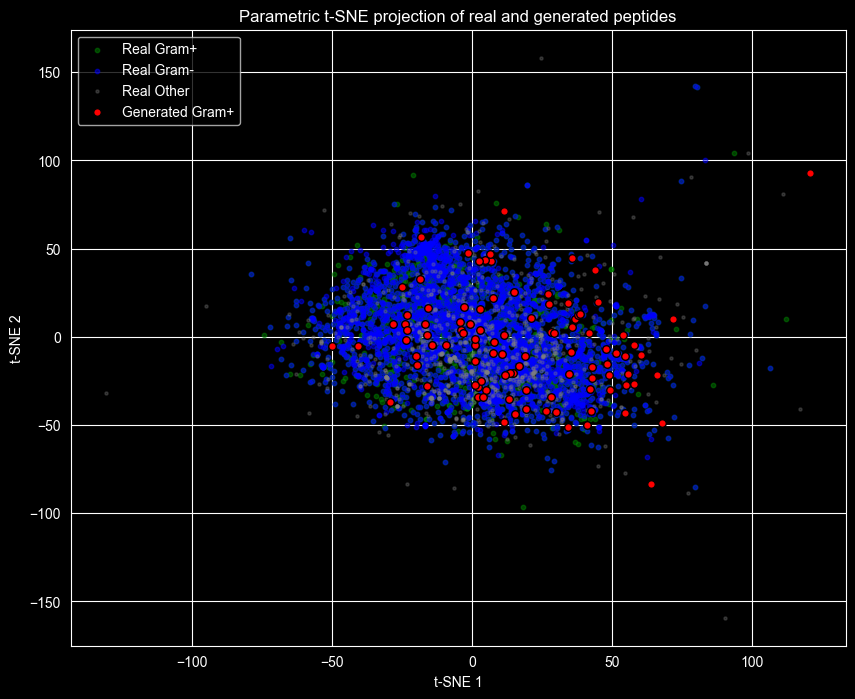

In [18]:
# generation and visualisation train and generated points on one t-SNE
def project_latents(latents):
    pt_model.eval()
    with torch.no_grad():
        latents_t = torch.FloatTensor(latents).to(device)
        return pt_model(latents_t).cpu().numpy()

# Получаем латентные векторы для сгенерированных последовательностей (например, для Gram+)
generated_seqs_examples = seqs_gp[:100]  # берём первые 100 из ранее сгенерированных
generated_tokens = [tokenize(seq, char2idx, max_len, add_sos_eos=True) for seq in generated_seqs_examples]
gen_lengths = [len(seq)+2 for seq in generated_seqs_examples]  # +2 SOS/EOS
gen_conditions = [cond_gram_pos] * len(generated_seqs_examples)

# Создаём датасет и загрузчик
gen_dataset = AMPDataset(generated_tokens, gen_lengths, gen_conditions)
gen_loader = DataLoader(gen_dataset, batch_size=len(gen_dataset))

gen_latents, _ = get_latent_vectors(model, gen_loader)  # (n_gen, latent_dim)
gen_2d = project_latents(gen_latents)

train_2d_param = project_latents(train_latents)

plt.figure(figsize=(10,8))

gram_pos_idx = train_conds[:,1] == 1   # is_anti_gram_positive
gram_neg_idx = train_conds[:,2] == 1   # is_anti_gram_negative
other_idx = ~(gram_pos_idx | gram_neg_idx)

plt.scatter(train_2d_param[gram_pos_idx,0], train_2d_param[gram_pos_idx,1], 
            c='green', label='Real Gram+', alpha=0.5, s=10)
plt.scatter(train_2d_param[gram_neg_idx,0], train_2d_param[gram_neg_idx,1], 
            c='blue', label='Real Gram-', alpha=0.5, s=10)
plt.scatter(train_2d_param[other_idx,0], train_2d_param[other_idx,1], 
            c='gray', label='Real Other', alpha=0.3, s=5)

plt.scatter(gen_2d[:,0], gen_2d[:,1], c='red', label='Generated Gram+', s=30, edgecolors='black')

plt.legend()
plt.title("Parametric t-SNE projection of real and generated peptides")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [19]:
import pickle
with open('vocab.pkl', 'wb') as f:
    pickle.dump({'char2idx': char2idx, 'idx2char': idx2char, 'max_len': max_len}, f)